In [1]:
# ==========================================
# STEP 1: Import Core Libraries
# ==========================================

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#(for later graph processing)
import torch

# Improve numpy printing
np.set_printoptions(suppress=True, precision=4)

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# ==========================================
# STEP 2A: Mount Google Drive
# ==========================================

from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully.")

Mounted at /content/drive
Google Drive mounted successfully.


In [3]:
# ==========================================
# STEP 2B: Verify File Exists
# ==========================================

PKL_PATH = "/content/drive/MyDrive/ResPlan.pkl"  

import os
print("File exists:", os.path.exists(PKL_PATH))

File exists: True


In [4]:
# ==========================================
# STEP 3: Load ResPlan PKL Dataset
# ==========================================

# Replace this with your actual file path
PKL_PATH = "/content/drive/MyDrive/ResPlan.pkl"

import pickle

with open(PKL_PATH, "rb") as f:
    data = pickle.load(f)

print("Dataset loaded successfully.")
print("Type of dataset:", type(data))
print("Number of plans:", len(data))

# Inspect the first sample
sample = data[0]
print("\nKeys in one sample:", sample.keys())

# look at metadata 
if "metadata" in sample:
    print("\nSample metadata:", sample["metadata"])

Dataset loaded successfully.
Type of dataset: <class 'list'>
Number of plans: 17000

Keys in one sample: dict_keys(['balcony', 'bathroom', 'bedroom', 'door', 'garden', 'inner', 'parking', 'pool', 'stair', 'veranda', 'wall', 'window', 'front_door', 'unitType', 'id', 'kitchen', 'land', 'net_area', 'area', 'neighbor', 'living', 'wall_depth', 'storage', 'graph'])


In [5]:
# ==========================================
# STEP 4: Inspect Room Geometry with Shapely
# ==========================================

from shapely.geometry import Polygon, MultiPolygon

room_type = 'bedroom'
room_geom = sample[room_type]

# Check type
print(f"Type of {room_type} geometry:", type(room_geom))

# Handle MultiPolygon vs Polygon
if isinstance(room_geom, MultiPolygon):
    # Pick the first polygon in the multipolygon
    first_polygon = list(room_geom.geoms)[0]
elif isinstance(room_geom, Polygon):
    first_polygon = room_geom
else:
    raise TypeError(f"Unexpected geometry type: {type(room_geom)}")

# Print coordinates of the polygon
print(f"Coordinates of the first {room_type}:")
print(list(first_polygon.exterior.coords))

Type of bedroom geometry: <class 'shapely.geometry.multipolygon.MultiPolygon'>
Coordinates of the first bedroom:
[(255.99999999999994, 88.36565539910274), (255.99999999999994, 19.035401767867448), (177.66374983342956, 19.035401767867448), (177.66374983342956, 88.36565539910274), (255.99999999999994, 88.36565539910274)]


## STEP 5: Data Visualization

In this section, we visualize:
- One floor plan with room polygons
- Room-wise area for that sample
- Dataset-level distributions (room counts and total area)

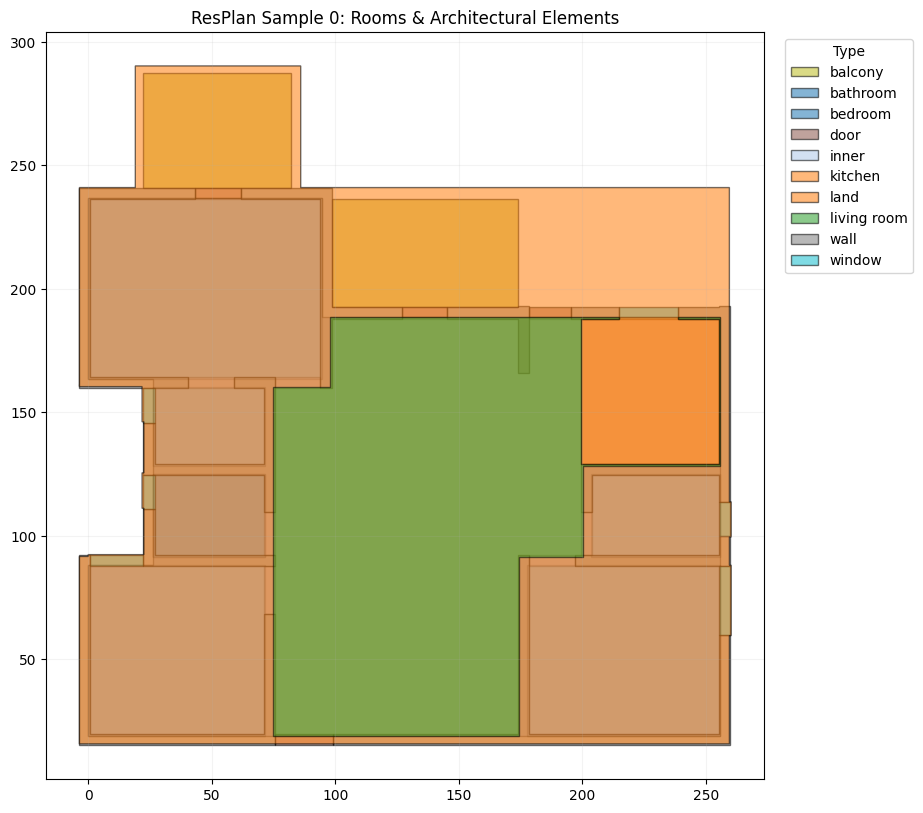

In [14]:
# ==========================================
# STEP 5A: Single ResPlan Floor Plan Visualization
# ==========================================

from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from matplotlib.patches import Patch

def extract_polygons(geometry):
    if isinstance(geometry, Polygon):
        return [geometry]
    if isinstance(geometry, MultiPolygon):
        return [poly for poly in geometry.geoms if not poly.is_empty]
    if isinstance(geometry, GeometryCollection):
        polygons = []
        for sub_geom in geometry.geoms:
            polygons.extend(extract_polygons(sub_geom))
        return polygons
    return []

def canonical_type(name):
    key = str(name).strip().lower()
    if "bed" in key:
        return "bedroom"
    if "kitchen" in key:
        return "kitchen"
    if "living" in key or "lounge" in key:
        return "living room"
    if "wall" in key:
        return "wall"
    if "door" in key:
        return "door"
    if "window" in key:
        return "window"
    if "balcony" in key:
        return "balcony"
    return key

sample_idx = 0
plan = data[sample_idx]

# Keep all geometry-like entries, skip metadata
plan_geometries = {k: v for k, v in plan.items() if k != "metadata"}

# Base palette for common room/element types
type_color_map = {
    "bedroom": "#1f77b4",
    "kitchen": "#ff7f0e",
    "living room": "#2ca02c",
    "wall": "#7f7f7f",
    "door": "#8c564b",
    "window": "#17becf",
    "balcony": "#bcbd22",
}

# Fallback colors for other types not listed above
fallback_cmap = plt.get_cmap("tab20")
fallback_index = 0

fig, ax = plt.subplots(figsize=(9, 9))
legend_map = {}

for raw_name, geometry in plan_geometries.items():
    polygons = extract_polygons(geometry)
    if not polygons:
        continue

    element_type = canonical_type(raw_name)
    if element_type not in type_color_map:
        type_color_map[element_type] = fallback_cmap(fallback_index % 20)
        fallback_index += 1

    face_color = type_color_map[element_type]

    for poly in polygons:
        x, y = poly.exterior.xy
        ax.fill(
            x, y,
            facecolor=face_color,
            edgecolor="black",
            linewidth=1.0,
            alpha=0.55
        )

    if element_type not in legend_map:
        legend_map[element_type] = Patch(
            facecolor=face_color,
            edgecolor="black",
            linewidth=1.0,
            alpha=0.55,
            label=element_type
        )

ax.set_title(f"ResPlan Sample {sample_idx}: Rooms & Architectural Elements")
ax.set_aspect("equal", adjustable="box")
ax.grid(alpha=0.15)

if legend_map:
    sorted_labels = sorted(legend_map.keys())
    ax.legend(
        [legend_map[label] for label in sorted_labels],
        sorted_labels,
        title="Type",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=True
    )

plt.tight_layout()
plt.show()

## STEP 6: Dataset Insight Visualizations

Each visualization below is in a separate code cell and uses shared precomputed metrics.

In [28]:
# ==========================================
# STEP 6A: Shared Preprocessing for Dataset Visualizations
# ==========================================

from collections import Counter
import networkx as nx
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from shapely.ops import unary_union

def extract_polygons(geometry):
    if isinstance(geometry, Polygon):
        return [geometry] if not geometry.is_empty else []
    if isinstance(geometry, MultiPolygon):
        return [poly for poly in geometry.geoms if not poly.is_empty]
    if isinstance(geometry, GeometryCollection):
        polygons = []
        for sub_geom in geometry.geoms:
            polygons.extend(extract_polygons(sub_geom))
        return polygons
    return []

def canonical_type(name):
    key = str(name).strip().lower()
    if "bed" in key:
        return "bedroom"
    if "kitchen" in key:
        return "kitchen"
    if "living" in key or "lounge" in key:
        return "living room"
    if "bath" in key or "toilet" in key or "wc" in key:
        return "bathroom"
    if "dining" in key:
        return "dining"
    if "balcony" in key:
        return "balcony"
    if "corridor" in key or "hall" in key or "passage" in key:
        return "corridor"
    if "wall" in key:
        return "wall"
    if "door" in key:
        return "door"
    if "window" in key:
        return "window"
    if "land" in key:
        return "land"
    if "inner" in key:
        return "inner"
    return key

def geometry_aspect_ratio(polys):
    if not polys:
        return np.nan
    geom = unary_union(polys)
    if geom.is_empty:
        return np.nan
    rect = geom.minimum_rotated_rectangle
    if rect.is_empty or not hasattr(rect, "exterior"):
        return np.nan
    coords = list(rect.exterior.coords)
    if len(coords) < 5:
        return np.nan
    edges = []
    for i in range(4):
        x1, y1 = coords[i]
        x2, y2 = coords[i + 1]
        edges.append(float(np.hypot(x2 - x1, y2 - y1)))
    long_edge = max(edges)
    short_edge = min(edges)
    if short_edge <= 1e-9:
        return np.nan
    return long_edge / short_edge

structural_types = {"wall", "door", "window", "inner", "land"}

room_records = []
rooms_per_plan = []
connectivity_counter = Counter()

for plan_idx, plan_i in enumerate(data):
    plan_items = []
    all_plan_polys = []

    for raw_name, geom in plan_i.items():
        if raw_name == "metadata":
            continue
        polygons = extract_polygons(geom)
        if not polygons:
            continue
        geom_union = unary_union(polygons)
        if geom_union.is_empty:
            continue

        room_type = canonical_type(raw_name)
        area = float(geom_union.area)
        aspect_ratio = geometry_aspect_ratio(polygons)
        centroid = geom_union.centroid

        plan_items.append({
            "raw_name": raw_name,
            "room_type": room_type,
            "geom": geom_union,
            "area": area,
            "aspect_ratio": aspect_ratio,
            "centroid_x": float(centroid.x),
            "centroid_y": float(centroid.y),
        })
        all_plan_polys.extend(polygons)

    rooms_per_plan.append(len(plan_items))

    if all_plan_polys:
        plan_union = unary_union(all_plan_polys)
        minx, miny, maxx, maxy = plan_union.bounds
        width = max(maxx - minx, 1e-9)
        height = max(maxy - miny, 1e-9)
    else:
        minx = miny = 0.0
        width = height = 1.0

    for item in plan_items:
        item["norm_x"] = (item["centroid_x"] - minx) / width
        item["norm_y"] = (item["centroid_y"] - miny) / height
        item["is_structural"] = item["room_type"] in structural_types
        item["plan_idx"] = plan_idx
        room_records.append(item)

    # Connectivity between non-structural room types
    usable_items = [it for it in plan_items if it["room_type"] not in structural_types]
    for i in range(len(usable_items)):
        for j in range(i + 1, len(usable_items)):
            if usable_items[i]["geom"].intersects(usable_items[j]["geom"]):
                a = usable_items[i]["room_type"]
                b = usable_items[j]["room_type"]
                edge = tuple(sorted((a, b)))
                connectivity_counter[edge] += 1

metrics_df = pd.DataFrame(room_records)
print("Prepared records:", len(metrics_df))
print("Unique types:", metrics_df["room_type"].nunique() if not metrics_df.empty else 0)
print("Plans:", len(data))

Prepared records: 187000
Unique types: 16
Plans: 17000


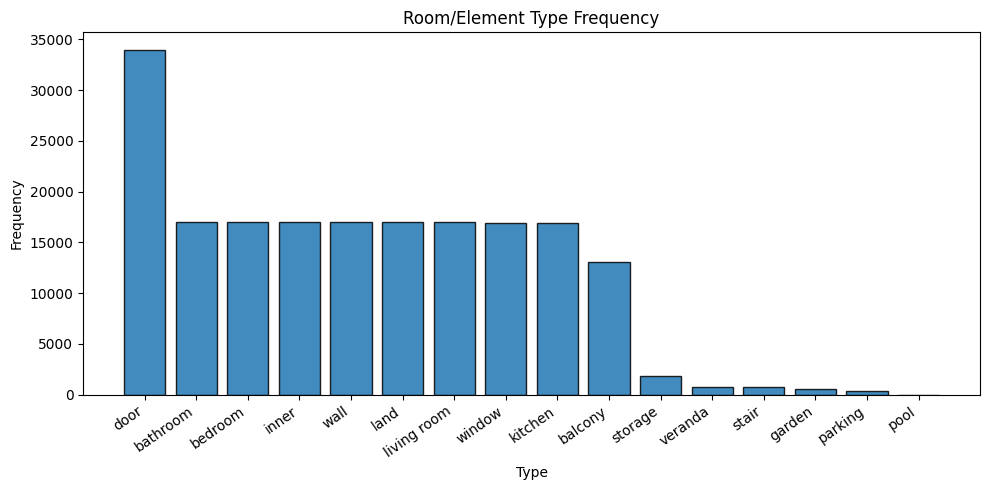

In [29]:
# 1) Room frequency: frequency of each room/element type

freq_series = metrics_df["room_type"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(freq_series.index, freq_series.values, edgecolor="black", alpha=0.85)
plt.title("Room/Element Type Frequency")
plt.xlabel("Type")
plt.ylabel("Frequency")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()

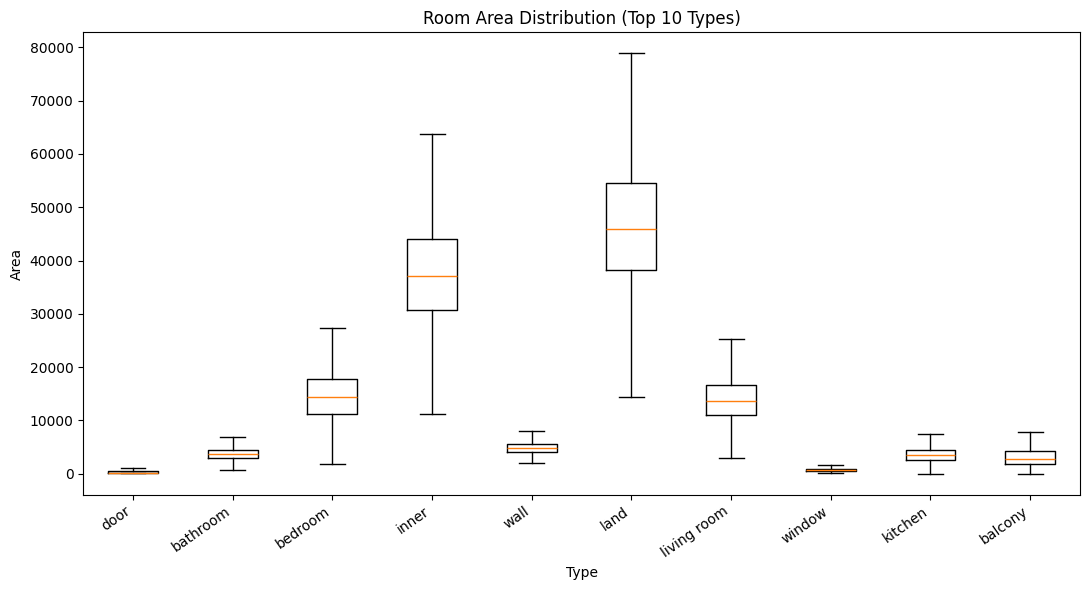

In [30]:
# 2) Room area distribution by type

top_types = metrics_df["room_type"].value_counts().head(10).index.tolist()
area_data = [metrics_df.loc[metrics_df["room_type"] == t, "area"].values for t in top_types]

plt.figure(figsize=(11, 6))
plt.boxplot(area_data, tick_labels=top_types, showfliers=False)
plt.title("Room Area Distribution (Top 10 Types)")
plt.xlabel("Type")
plt.ylabel("Area")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()

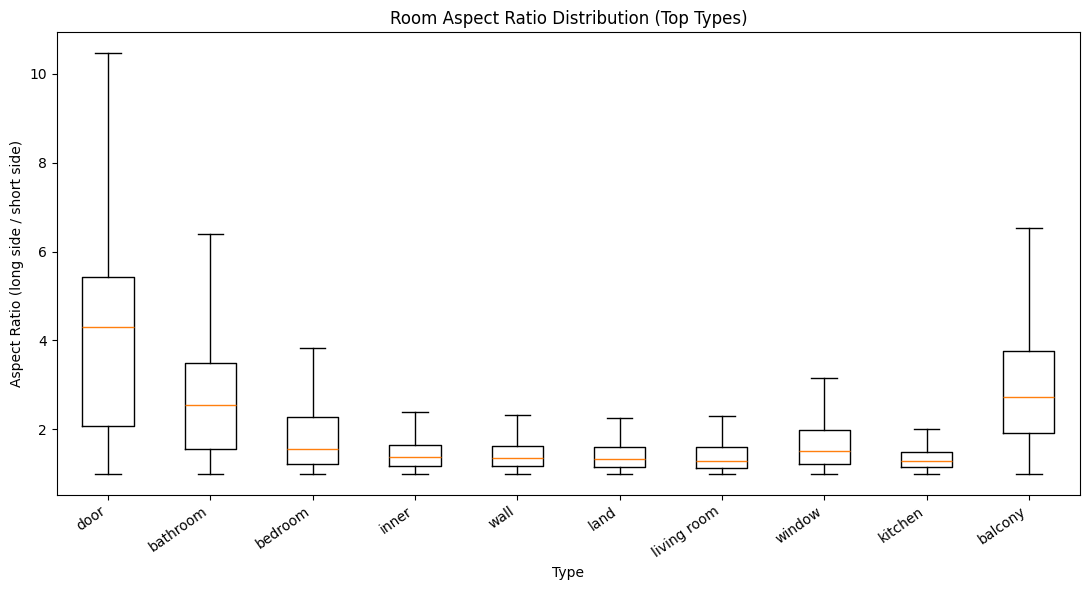

In [31]:
# 3) Room aspect ratio distribution by type

top_types = metrics_df["room_type"].value_counts().head(10).index.tolist()
ratio_data = []
ratio_labels = []

for room_t in top_types:
    vals = metrics_df.loc[metrics_df["room_type"] == room_t, "aspect_ratio"].dropna().values
    if len(vals) > 0:
        ratio_data.append(vals)
        ratio_labels.append(room_t)

plt.figure(figsize=(11, 6))
plt.boxplot(ratio_data, tick_labels=ratio_labels, showfliers=False)
plt.title("Room Aspect Ratio Distribution (Top Types)")
plt.xlabel("Type")
plt.ylabel("Aspect Ratio (long side / short side)")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()

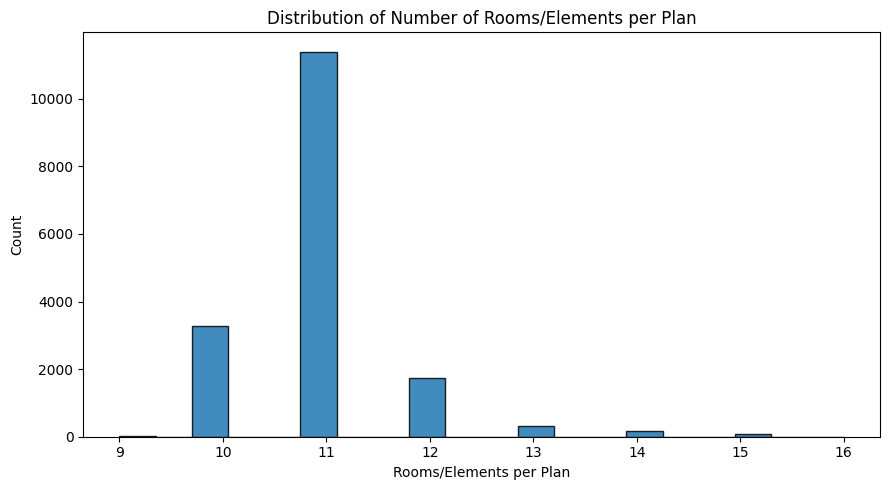

Mean rooms/elements per plan: 11.0
Median rooms/elements per plan: 11


In [32]:
# 4) Number of rooms per plan

plt.figure(figsize=(9, 5))
plt.hist(rooms_per_plan, bins=20, edgecolor="black", alpha=0.85)
plt.title("Distribution of Number of Rooms/Elements per Plan")
plt.xlabel("Rooms/Elements per Plan")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("Mean rooms/elements per plan:", round(np.mean(rooms_per_plan), 2))
print("Median rooms/elements per plan:", int(np.median(rooms_per_plan)))

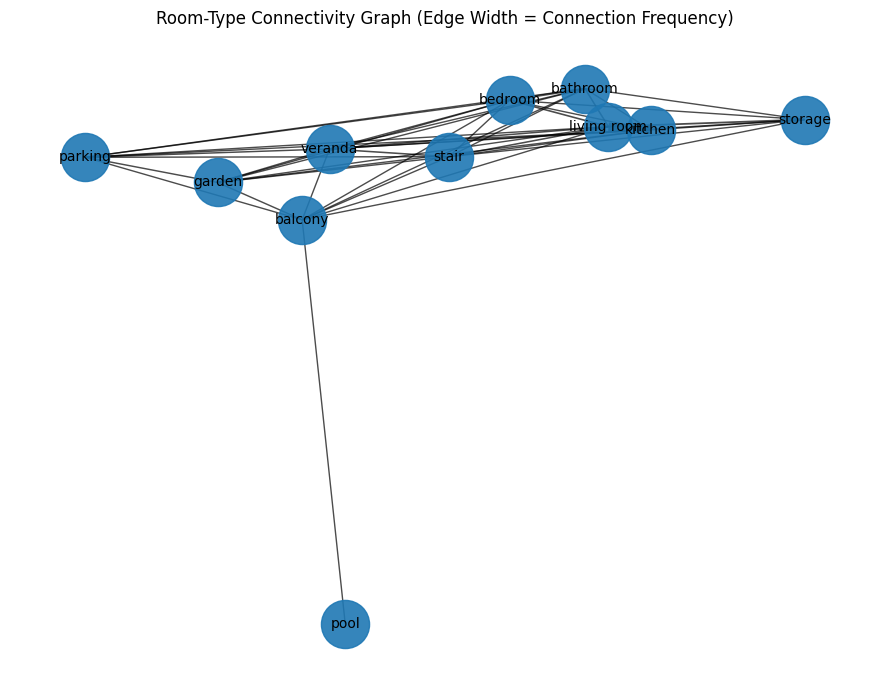

In [33]:
# 5) Connectivity pattern of rooms (type-level graph)

conn_graph = nx.Graph()
for (type_a, type_b), w in connectivity_counter.items():
    conn_graph.add_edge(type_a, type_b, weight=w)

plt.figure(figsize=(9, 7))
if conn_graph.number_of_nodes() > 0:
    pos = nx.spring_layout(conn_graph, seed=42, k=0.8)
    edge_weights = [conn_graph[u][v]["weight"] for u, v in conn_graph.edges()]
    max_w = max(edge_weights) if edge_weights else 1
    widths = [1 + 5 * (w / max_w) for w in edge_weights]

    nx.draw_networkx_nodes(conn_graph, pos, node_size=1200, alpha=0.9)
    nx.draw_networkx_labels(conn_graph, pos, font_size=10)
    nx.draw_networkx_edges(conn_graph, pos, width=widths, alpha=0.7)
    plt.title("Room-Type Connectivity Graph (Edge Width = Connection Frequency)")
    plt.axis("off")
else:
    plt.title("No connectivity relationships found")
    plt.axis("off")

plt.tight_layout()
plt.show()

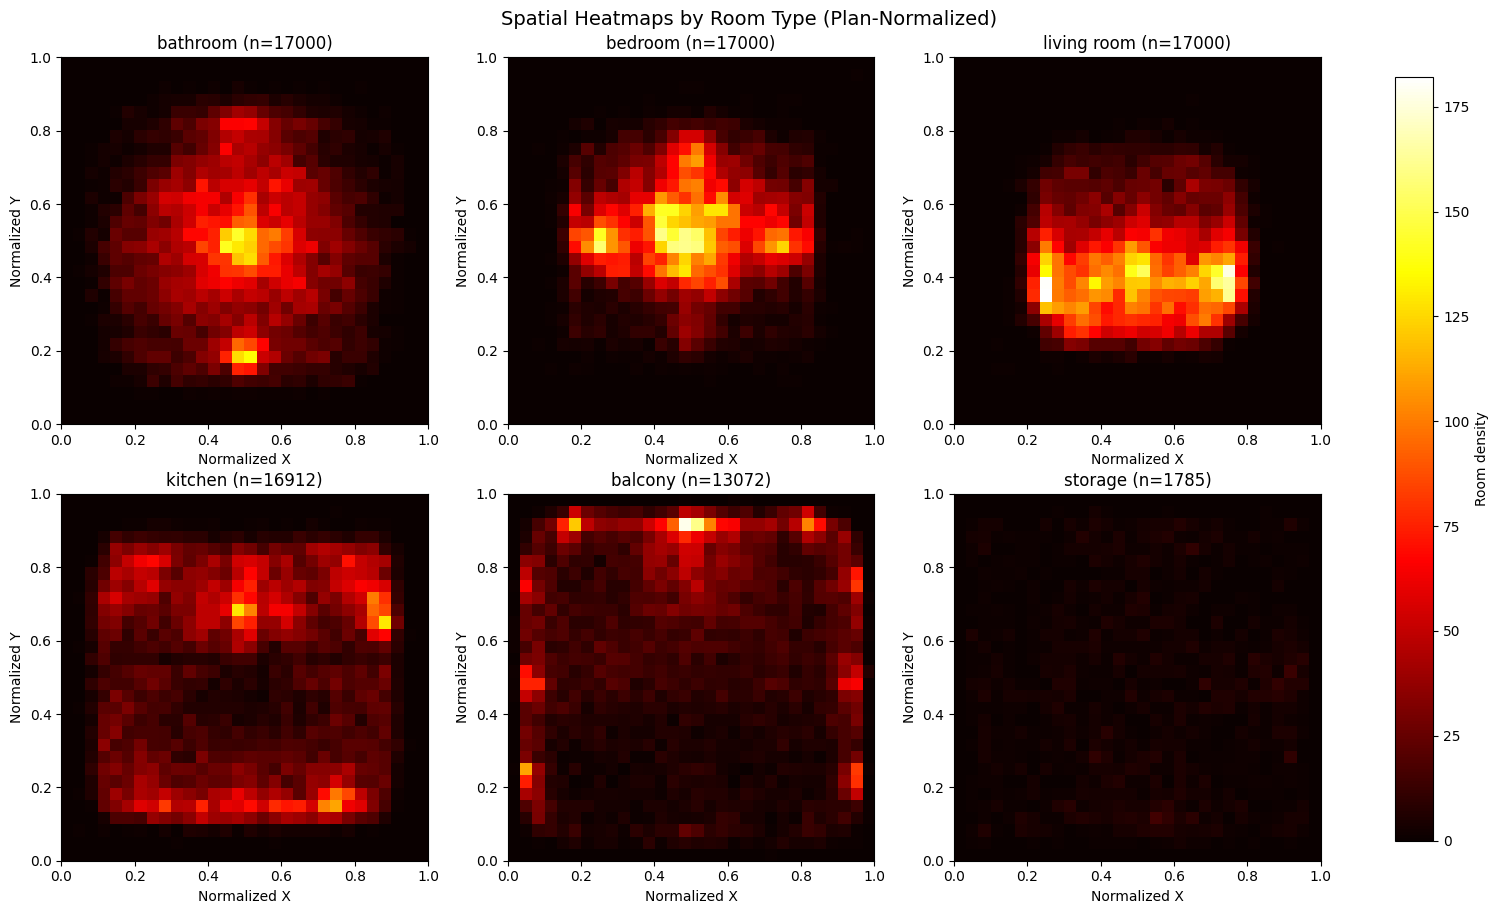

In [37]:
# 6) Spatial heatmap of room locations (normalized within each plan)

usable_df = metrics_df.loc[~metrics_df["is_structural"]].copy()

plt.figure(figsize=(7, 6))
hist = plt.hist2d(
    usable_df["norm_x"],
    usable_df["norm_y"],
    bins=30,
    cmap="hot"
 )
plt.colorbar(hist[3], label="Room density")
plt.title("Spatial Heatmap of Room Centroids (Plan-Normalized)")
plt.xlabel("Normalized X")
plt.ylabel("Normalized Y")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

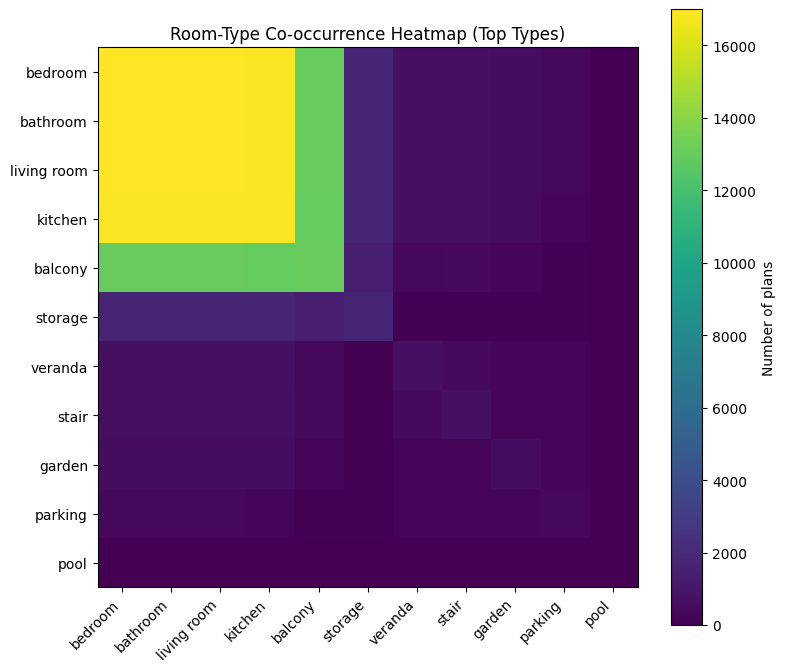

In [35]:
# 7)  Room-type co-occurrence heatmap across plans

plan_type_sets = []
for plan_idx in range(len(data)):
    types_in_plan = set(
        metrics_df.loc[metrics_df["plan_idx"] == plan_idx, "room_type"].tolist()
    )
    types_in_plan = {t for t in types_in_plan if t not in structural_types}
    plan_type_sets.append(types_in_plan)

type_counts = Counter()
for type_set in plan_type_sets:
    type_counts.update(type_set)

top_types = [t for t, _ in type_counts.most_common(12)]
co_matrix = np.zeros((len(top_types), len(top_types)), dtype=int)

for type_set in plan_type_sets:
    for i, t1 in enumerate(top_types):
        if t1 not in type_set:
            continue
        for j, t2 in enumerate(top_types):
            if t2 in type_set:
                co_matrix[i, j] += 1

plt.figure(figsize=(8, 7))
im = plt.imshow(co_matrix, cmap="viridis")
plt.colorbar(im, label="Number of plans")
plt.title("Room-Type Co-occurrence Heatmap (Top Types)")
plt.xticks(range(len(top_types)), top_types, rotation=45, ha="right")
plt.yticks(range(len(top_types)), top_types)
plt.tight_layout()
plt.show()